In [1]:
!pip install -U -q lightautoml

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.1 requires aiohttp, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.1 which is incompatible.
dask-expr 1.1.1 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
featuretools 1.31.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
fitter 1.7.0 requires joblib<2.0.0,>=1.3.1, but you have joblib 1.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
momepy 0.7.0 requires shapely

# Configs and Imports

In [2]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import torch
import optuna
import glob
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TARGET_NAME = 'Target'
TEST_SIZE = 0.15
N_THREADS = 4
TIMEOUT = 3600 * 11
N_FOLDS = 5
SEED = 27

In [4]:
np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

# Loading and Processing the Datasets

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [6]:
label_encoder = LabelEncoder()
train[TARGET_NAME] = label_encoder.fit_transform(train[TARGET_NAME])

class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
reverse_class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

print(class_mapping)
print(reverse_class_mapping)

{'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
{0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}


# Setting up K-Fold CV and Training Functions

In [7]:
os.mkdir('test_preds')
os.mkdir('test_pred_probs')

In [8]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_pred_probs = np.zeros((len(train), train[TARGET_NAME].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET_NAME), train[TARGET_NAME])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    automl = TabularUtilizedAutoML(
        task=Task(name='multiclass'),
        timeout=TIMEOUT // N_FOLDS,
        cpu_limit=N_THREADS,
        reader_params={
            'n_jobs': N_THREADS,
            'cv':  N_FOLDS,
            'random_state': SEED
        },
        tuning_params = {'max_tuning_time': 1800},
    )

    _ = automl.fit_predict(
        _train,
        roles={'target': TARGET_NAME},
        verbose=1
    )
    
    pred_probs = automl.predict(_val).data
    preds = pred_probs.argmax(axis=1)
    oof_pred_probs[val_idx] = pred_probs
    
    fold_accuracy = accuracy_score(_val[TARGET_NAME], preds)
    
    test_pred_probs = automl.predict(test).data
    
    test_preds = test_pred_probs.argmax(axis=1)
    test_preds = pd.DataFrame({TARGET_NAME: test_preds}, index=test.index)
    test_preds[TARGET_NAME] = test_preds[TARGET_NAME].map(reverse_class_mapping)
    test_preds.to_csv(f'test_preds/fold_{fold_idx}_test_preds_acc-{fold_accuracy:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.columns = reverse_class_mapping.values()
    test_pred_probs.to_csv(f'test_pred_probs/fold_{fold_idx}_test_pred_probs_acc-{fold_accuracy:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET_NAME].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_accuracy
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET_NAME], pred_probs, multi_class='ovo')
    
    print(f'Fold {fold_idx} - Accuracy: {fold_accuracy}')
    
    del automl

[14:59:42] Start automl utilizator with listed constraints:
[14:59:42] - time: 7920.00 seconds
[14:59:42] - CPU: 4 cores
[14:59:42] - memory: 16 GB

[14:59:42] If one preset completes earlier, next preset configuration will be started

[14:59:42] ==================================================
[14:59:42] Start 0 automl preset configuration:
[14:59:42] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[14:59:42] Stdout logging level is INFO.
[14:59:42] Task: multiclass

[14:59:42] Start automl preset with listed constraints:
[14:59:42] - time: 7920.00 seconds
[14:59:42] - CPU: 4 cores
[14:59:42] - memory: 16 GB

[14:59:42] Train data shape: (61214, 37)

[14:59:52] Layer 1 train process start. Time left 7909.62 secs
[14:59:58] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:00:52] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.4446786174452991
[15:00:52] Lvl_0

In [9]:
with open('laml_oof_pred_probs.pkl', 'wb') as f:
    pickle.dump(oof_pred_probs, f)

In [10]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET_NAME], oof_pred_probs.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET_NAME], oof_pred_probs, multi_class='ovo')
histories['All']['pred_probs'] = oof_pred_probs
histories['All']['preds'] = oof_pred_probs.argmax(axis=1)
histories['All']['y'] = train[TARGET_NAME].values

# Visualizing The Results

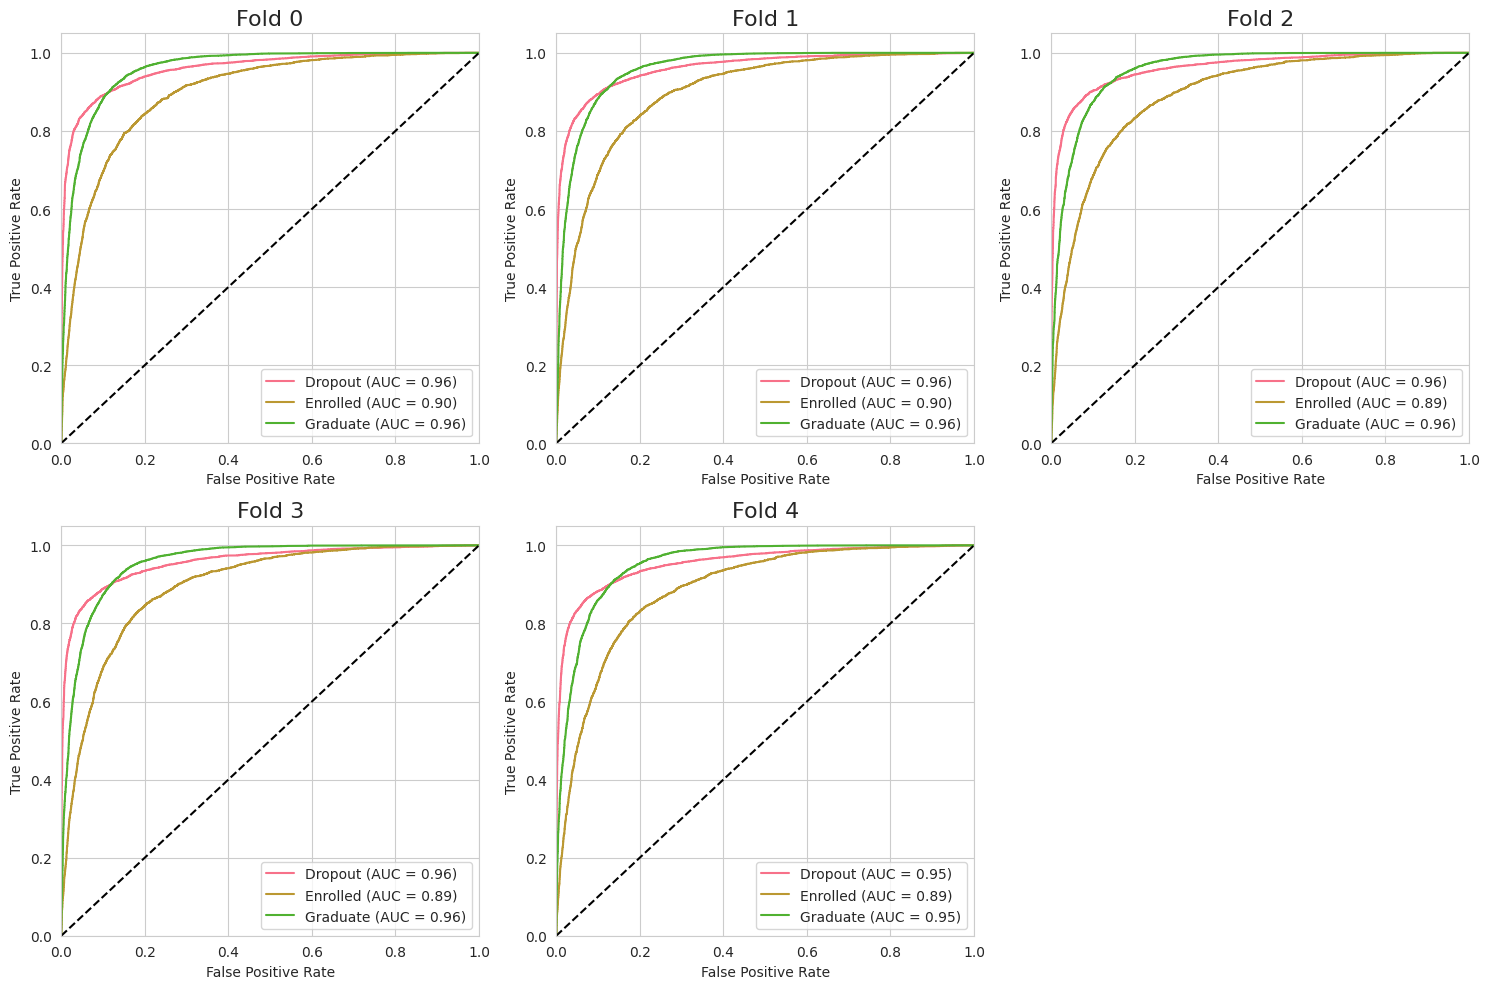

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_class_mapping[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

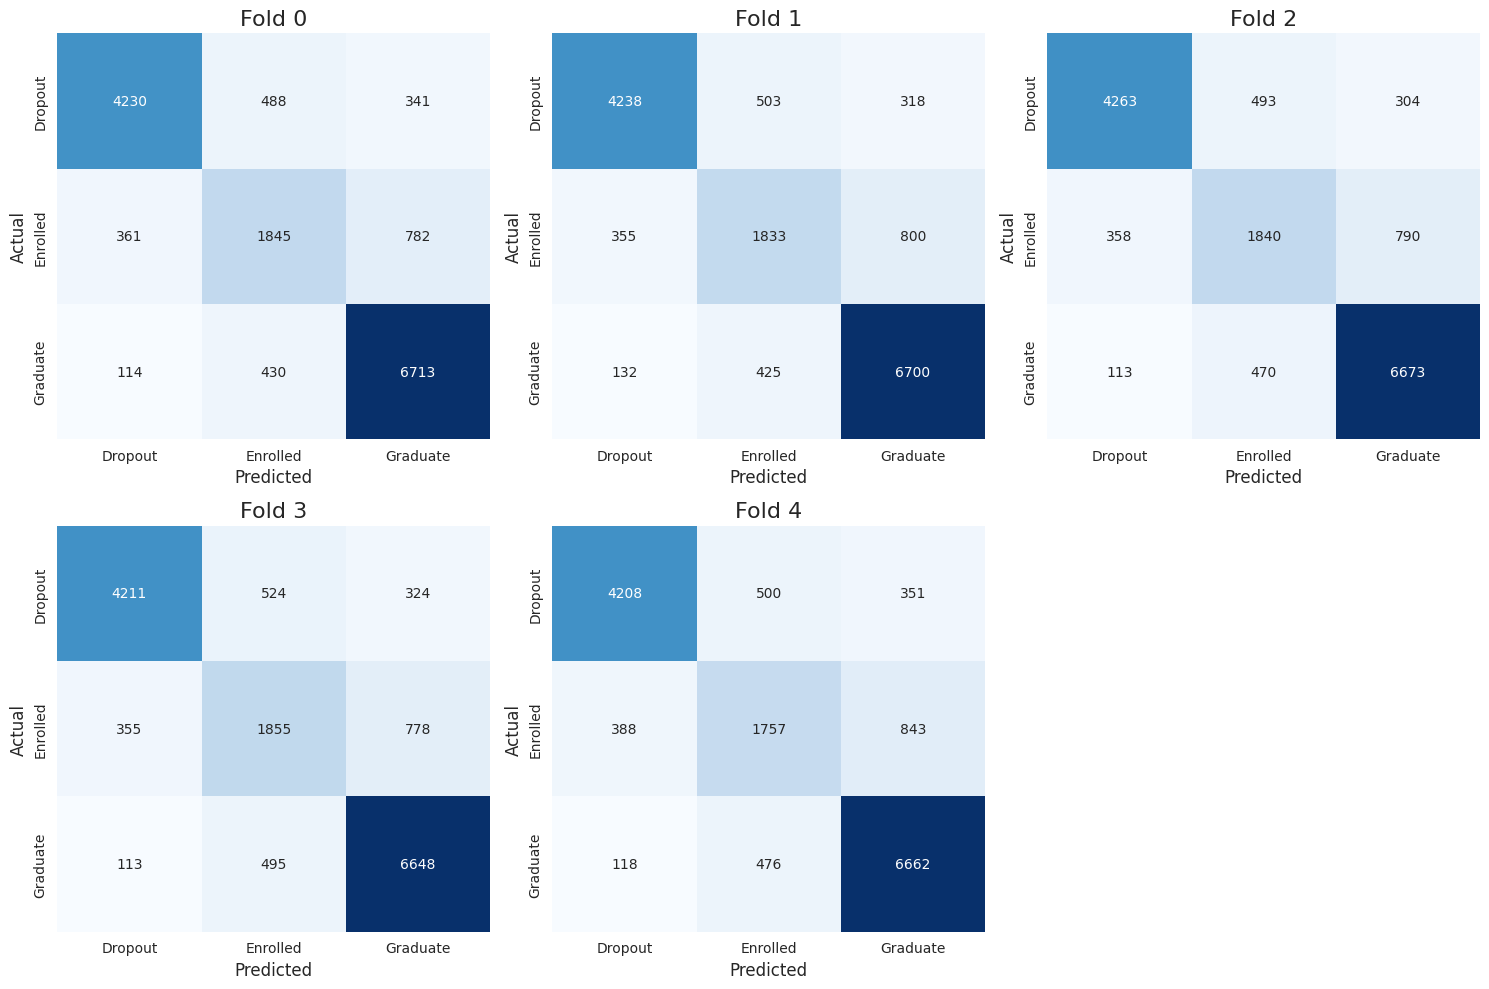

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=class_mapping.keys(),
        yticklabels=class_mapping.keys()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

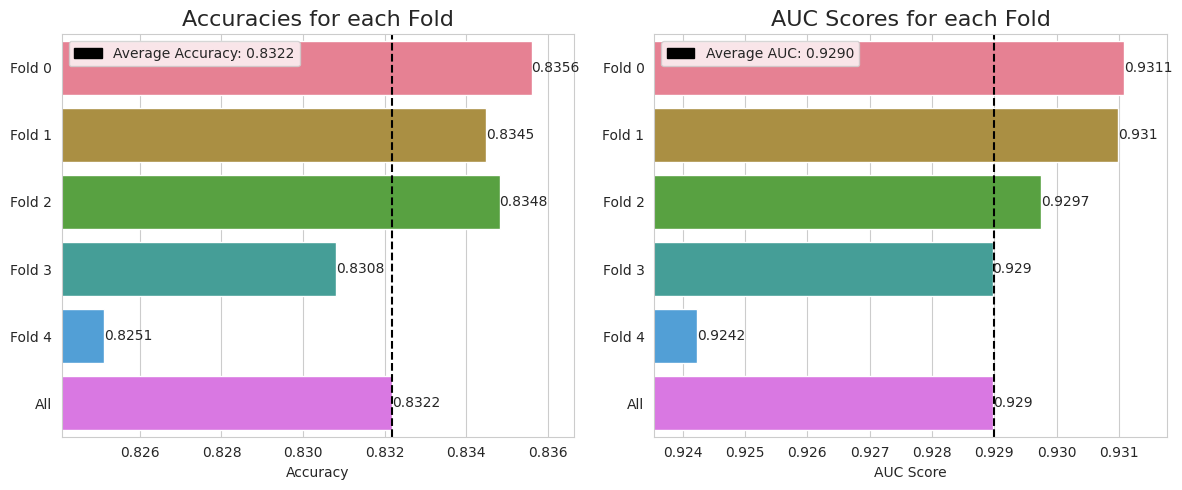

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

min_acc = min(accuracies)
max_acc = max(accuracies)
acc_padding = (max_acc - min_acc) * 0.1
acc_lower_limit = min_acc - acc_padding
acc_upper_limit = max_acc + acc_padding

acc_barplot = sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim(left=acc_lower_limit, right=acc_upper_limit)
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.4f}')
axs[0].legend(handles=[blue_patch], loc='best')
for i, score in enumerate(accuracies):
    acc_barplot.text(score, i, round(score, 4), va = 'center')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

min_auc = min(auc_scores)
max_auc = max(auc_scores)
auc_padding = (max_auc - min_auc) * 0.1
auc_lower_limit = min_auc - auc_padding
auc_upper_limit = max_auc + auc_padding

auc_barplot = sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim(left=auc_lower_limit, right=auc_upper_limit)
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.4f}')
axs[1].legend(handles=[blue_patch], loc='best')
for i, score in enumerate(auc_scores):
    auc_barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [14]:
oof_files = glob.glob('test_pred_probs/fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in oof_files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

with open('laml_test_pred_probs.pkl', 'wb') as f:
    pickle.dump(submission.values, f)

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'laml_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Enrolled
76522,76522,Enrolled
